In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.cluster import VAE_Cluster
from module.vmt import VMT, TemplateD
from module.vae import GaussianKLLoss
from dataset import KKDayUser, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
import seaborn as sns
from collections import namedtuple

In [3]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [22]:
from dataset import TemPest, tempest_collate
valid_dataset = TemPest(args.cache_path, 'valid')
print(len(valid_dataset))
eval_dataloader = torch.utils.data.DataLoader(valid_dataset, num_workers=8,
                        collate_fn=tempest_collate, batch_size=32, shuffle=False, drop_last=True)

dataset/valid.pt
cache/tempest_word_word2idx.pkl
1761


### Lets Visualize template first

In [23]:
log_name = 'save/tempest_rec-2020-07-19-12-42-58/'
checkpoint = 'checkpoint_40000.pt'

from module.vmt import VMT
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
id_mapping = torch.load(os.path.join(args.cache_path, 'id_mapping.pt'))
user_size = len(id_mapping['user2id'])
user_size = user_size
prod_size = len(id_mapping['prod2id'])
id2user = { value: key for key, value in id_mapping['user2id'].items() }

model = VMT(args.gen_embed_dim, args.vocab_size,
            enc_hidden_size=500, dec_hidden_size=500, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset, user_embedding=True, user_size=user_size,
            max_seq_len=args.max_seq_len-1, gpu=True).cuda()
model.load_state_dict(torch.load(os.path.join(log_name,checkpoint))['model'])


<All keys matched successfully>

Generate examples

In [24]:
sentences, references = [], []
temp_latent = []; temp_outputs= []
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        empty_users = users == -1
        batch_size = len(empty_users)
        users_filled = users.detach()
        users_filled[empty_users] = torch.randint(0, user_size, ( int(empty_users.sum()),  ))

        if cfg.CUDA:
            src_inputs = src_inputs.cuda()
            target = target.cuda()
            tmp = tmp.cuda()
            inputs = inputs.cuda()
            users_filled = users_filled.cuda()

        desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        for latent_ in tmp_latent:
            temp_latent.append(latent_.cpu().numpy().flatten())
        for latent_ in tmp_outputs:
            temp_outputs.append(latent_.cpu().numpy())
        user_embeddings = model.user_embedding( users_filled )
        _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
                desc_outputs, tmp_outputs,
                max_length=target.shape[1])

        for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
            reference = []
            for token in sent_token:
                if token.item() == Constants.EOS:
                    break
                reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
            references.append(''.join(reference))

            sent = output_title[idx]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            sentences.append(''.join(sentence))

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [25]:
X, title = [], []
print(len(temp_latent))
for idx, latent in enumerate(temp_latent):
    X.append(latent)
    title.append(references[idx])
temp_outputs = np.array(temp_outputs)
title = np.array(title)
X = np.array(X)

1760


### Visualize categorical distribution of the first template latent

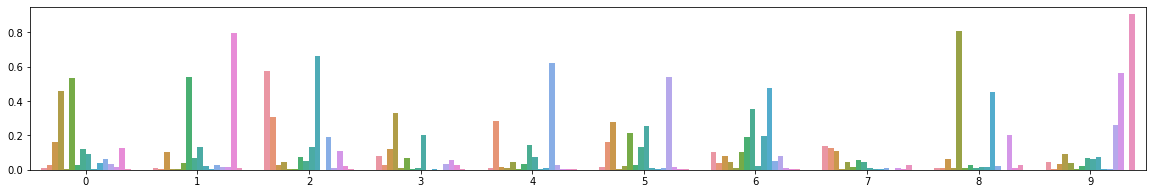

In [26]:
plt.rcParams["figure.figsize"] = (20,3)

data = {'y': [], 'bins': [], 'type': []}
for idx, latent in enumerate(X[0].reshape(args.tmp_latent_dim, args.tmp_cat_dim)):
    data['y'] += list(range(len(latent)))
    data['bins'] += list(latent)
    data['type'] += list([idx]*len(latent))
g = sns.barplot(x='y', y='bins', data=data, hue='type')
g.legend_.remove()

## Sample some latent as reference

In [27]:
with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0 and idx > 20:
            print('found')
            break

found


## Sample other latent as target

In [28]:
cnt = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        cnt += 1
        users2 = batch['users']
        non_empty_users = users2 != -1
        if cfg.CUDA:
            users2 = users2[non_empty_users].cuda()
        if non_empty_users.sum() > 0 and cnt > 10:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


found


Generate reference title from reference latent

In [29]:
desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
tmp_outputs, tmp_latent = model.encode_tmp(tmp)
user_embeddings = model.user_embedding( users )
_, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
original_sentences = []
original_pairs = []
for idx, sent in enumerate(output_title.cpu()):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_pairs.append("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_sentences.append(''.join(sentence[:50]).strip())

user: 9c1cb59c-2465-4330-a9e4-5ba05e7ba02c | 【台北包車】台北、】九份火山、十分、懷舊出發一日遊
user: 6de032df-dd87-4e31-a9d0-a954c12bb925 | 【超值組合】新加坡迪士尼體驗》兌換券
user: f3f287c8-a445-458a-a8ba-dd04d2e0a15e | 【九份茶旅】坪林茶樓】日月潭號茶食烏龍茶點燈季烏龍茶&美食二擇晚餐)
user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西交通票券】關西周遊券KANSAITHRUPASS2日券/3日券（韓國機場領取）
user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【馬來西亞叢林】憤怒鳥樂園Angry樂園門票＋電子票門票
user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【一山澳洲秘密】】之旅
user: 6af4733d-e4f1-45e4-b026-dcb3d5813083 | 【全專屬私人天堂】機車海鮮島＋水/沙美島海灘
user: 0bb0336a-3606-4de8-b620-ad328b7a375a | 【水陸海釣】乘庭園海釣上邊
user: ca98e7ae-ab72-4935-b430-ff22d26fc84c | 【東北角遊太陽網美遊】】鼻頭角、官、、DIY坐擁賞潮境
user: 799dae36-4794-4464-bb3f-aa17455686a4 | 【澳洲海洋最基地】墨爾本門票門票優惠門票
user: 8ced412d-960c-416e-a300-f3c3a93649a3 | 【隨海上巴士】暢遊薩爾斯堡隨上隨下遊船遊船船票


In [31]:
user2_embeddings = model.user_embedding( users2[:6,] )
_, output_title = model.decode(
        tmp_latent[:6],
        #control_latent[:6].cuda(), 
        desc_latent[:6], user2_embeddings[:6], 
        desc_outputs[:6], tmp_outputs[:6],
        max_length=target.shape[1])
for idx, (sent, origin_pair) in enumerate(zip(output_title, original_pairs)):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : "+origin_pair)
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old : user: 9c1cb59c-2465-4330-a9e4-5ba05e7ba02c | 【台北包車】台北、】九份火山、十分、懷舊出發一日遊
new : user: ad164a18-3d1d-4277-99ec-ea65cb189f4d | 【台北經典景點】十分克拉溝一日、、遊遊遊

old : user: 6de032df-dd87-4e31-a9d0-a954c12bb925 | 【超值組合】新加坡迪士尼體驗》兌換券
new : user: 19eb6217-812c-4776-93ed-0983578602e1 | 【超值組合】新加坡迪士尼體驗》兌換券

old : user: f3f287c8-a445-458a-a8ba-dd04d2e0a15e | 【九份茶旅】坪林茶樓】日月潭號茶食烏龍茶點燈季烏龍茶&美食二擇晚餐)
new : user: c12322ca-2887-47da-a95b-5fc463546811 | 【九份茶旅】坪林老爺號日月潭號茶食烏龍茶-烏龍茶&下午茶套餐券

old : user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西交通票券】關西周遊券KANSAITHRUPASS2日券/3日券（韓國機場領取）
new : user: dfb07b56-0de7-4fa2-87ca-2439bd40efd9 | 【關西交通票券】關西周遊券KANSAITHRUPASS2日券/3日券（韓國機場領取）

old : user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【馬來西亞叢林】憤怒鳥樂園Angry樂園門票＋電子票門票
new : user: 5c187203-38ca-4bb4-a06c-b1f265369629 | 【馬來西亞叢林】憤怒鳥樂園Angry樂園門票＋有門票

old : user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【一山澳洲秘密】】之旅
new : user: b2a0019b-33d2-4077-9980-9364d0211f3e | 【一日】】白色必之旅



Can we randomly sample template latent for use? ( Only applicable for model without BiSET )

In [32]:
latent_dim = args.tmp_latent_dim
categorical_dim = args.tmp_cat_dim
M =  args.tmp_cat_dim * args.tmp_latent_dim
np_y = np.zeros((M, categorical_dim), dtype=np.float32)
np_y[range(M), np.random.choice(categorical_dim, M)] = 1
np_y = np.reshape(np_y, [ M // latent_dim, latent_dim, categorical_dim])[:6, :,:]

In [33]:
random_sample = torch.from_numpy(np_y).view(6, latent_dim * categorical_dim).cuda()
_, output_title = model.decode(
        random_sample,
        #control_latent[:6].cuda(), 
        desc_latent[:6], user_embeddings[:6], 
        desc_outputs[:6], tmp_outputs[:6],
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : ",original_pairs[idx])
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old :  user: 9c1cb59c-2465-4330-a9e4-5ba05e7ba02c | 【台北包車】台北、】九份火山、十分、懷舊出發一日遊
new : user: ad164a18-3d1d-4277-99ec-ea65cb189f4d | 【台灣包車遊遊】】九份、、、、北海岸清境地區）

old :  user: 6de032df-dd87-4e31-a9d0-a954c12bb925 | 【超值組合】新加坡迪士尼體驗》兌換券
new : user: 19eb6217-812c-4776-93ed-0983578602e1 | 【超值組合》】新加坡VR體驗》優惠門票

old :  user: f3f287c8-a445-458a-a8ba-dd04d2e0a15e | 【九份茶旅】坪林茶樓】日月潭號茶食烏龍茶點燈季烏龍茶&美食二擇晚餐)
new : user: c12322ca-2887-47da-a95b-5fc463546811 | 【九份茶旅】坪林茶樓】悲情宮城茶食-茶坊雙人套餐餐券二擇沙拉吧)＋麻辣鍋

old :  user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西交通票券】關西周遊券KANSAITHRUPASS2日券/3日券（韓國機場領取）
new : user: dfb07b56-0de7-4fa2-87ca-2439bd40efd9 | 【關西機場領取件關西周遊券】關西周遊券

old :  user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【馬來西亞叢林】憤怒鳥樂園Angry樂園門票＋電子票門票
new : user: 5c187203-38ca-4bb4-a06c-b1f265369629 | 【馬來西亞樂園】韓國迪士尼樂園門票

old :  user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【一山澳洲秘密】】之旅
new : user: b2a0019b-33d2-4077-9980-9364d0211f3e | 【參觀之】】】吳哥窟大漂流，兩的殺戮奇景



Visualize template latent 

In [40]:
pca = PCA(n_components=2)
one_hot_x = [  torch.softmax(torch.from_numpy(row).reshape(10, 16), dim=-1).numpy()[1]  for row in X   ]
X_r = pca.fit_transform(X)
nbrs = SpectralClustering(n_clusters=3).fit(X_r)
y = nbrs.labels_
print(set(y))

{0, 1, 2}


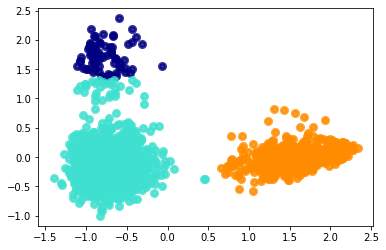

In [42]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()

colors = ['navy', 'turquoise', 'darkorange']
target_names = list(range(len(colors)))
lw = 3
for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [43]:
no_bracket_latent = X[y==0][:6]
no_bracket_latent_out = temp_outputs[y==0][:6]
templates = title[y==0][:6]

output_titles = []
for idx, (_latent, _latent_output) in enumerate(zip(no_bracket_latent, temp_outputs)):
    _latent = torch.from_numpy(_latent).view(1, latent_dim * categorical_dim).cuda()
    _latent_output = torch.from_numpy(_latent_output).unsqueeze(0).cuda()
    _, output_title = model.decode(
            _latent,
            desc_latent[[idx]], user2_embeddings[[idx]], 
            desc_outputs[[idx]], _latent_output,
            max_length=target.shape[1])
    output_titles.append(output_title.cpu())

output_titles = torch.cat(output_titles)
for idx, sent in enumerate(output_titles):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print('target template   %s' % templates[idx])
    print('origin gen title %s ' % original_sentences[idx])
    print('new gen title    %s\n' % ''.join(sentence[:50]).strip())
#     print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

target template   【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽
origin gen title 【台北包車】台北、】九份火山、十分、懷舊出發一日遊 
new gen title    【台北經典景點】十分內排、望安、十分、拙政園懷舊一日遊遊（）））

target template   【日本阿爾卑斯X童話北陸】立山黑部、白川鄉合掌村、兼六園、高山古街、松本城五天四夜多日遊
origin gen title 【超值組合】新加坡迪士尼體驗》兌換券 
new gen title    【浪漫田急】】】VR體驗小時板兌換券

target template   【加拿大Wi-Fi機租借】4G高速上網無流量限制/不降速（香港機場領取）
origin gen title 【九份茶旅】坪林茶樓】日月潭號茶食烏龍茶點燈季烏龍茶&美食二擇晚餐) 
new gen title    【九份茶旅】美食茶樓】日月潭號茶食-茶坊雙人套餐餐券二擇步行導覽)

target template   【免排隊快捷通道】三合一套票：杜莎夫人蠟像館門票摩天台太平山頂纜車
origin gen title 【關西交通票券】關西周遊券KANSAITHRUPASS2日券/3日券（韓國機場領取） 
new gen title    【關西機場交通】關西周遊券】KANSAI周遊券KANSAITHRU3日券3日券機場實體票

target template   【京都賞櫻一日遊】將軍塚青龍殿、高台寺、祇園圓山公園、</UNK>上鐵道、南禪寺
origin gen title 【馬來西亞叢林】憤怒鳥樂園Angry樂園門票＋電子票門票 
new gen title    【馬來西亞叢林】憤怒鳥樂園樂園樂園門票

target template   【熱門景點包車一日遊】打狗英國領事館、高雄衛武營、台南億載金城、台江國家公園（高雄出發、台南結束）
origin gen title 【一山澳洲秘密】】之旅 
new gen title    【參觀最神秘】】私房之旅，走入山古城奇景



In [44]:
print(title[y==0][:60])

['【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽'
 '【日本阿爾卑斯X童話北陸】立山黑部、白川鄉合掌村、兼六園、高山古街、松本城五天四夜多日遊'
 '【加拿大Wi-Fi機租借】4G高速上網無流量限制/不降速（香港機場領取）'
 '【免排隊快捷通道】三合一套票：杜莎夫人蠟像館門票摩天台太平山頂纜車'
 '【京都賞櫻一日遊】將軍塚青龍殿、高台寺、祇園圓山公園、</UNK>上鐵道、南禪寺'
 '【熱門景點包車一日遊】打狗英國領事館、高雄衛武營、台南億載金城、台江國家公園（高雄出發、台南結束）'
 '【熱門景點包車一日遊】高雄茂林情人谷、美濃客家文物館、旗山老街（高雄出發、台南結束）'
 '【新竹包車一日遊】新豐紅樹林、賞蟹步道、海之聲、</UNK></UNK>（台北出發）'
 '【高雄義大世界住宿】義大天悅飯店一</UNK>＋佛光山佛陀紀念館來回車票＋茶禪一味體驗＋（9-11月入住）摩天輪票卷'
 '【熱門景點包車一日遊】台中勤美綠園道、</UNK>山之眼、高雄阿公店水庫（台中出發、高雄結束）'
 '【麗星郵輪】處女星號・春夏航程五折優惠・6/10、6/20基隆港出發到沖繩、鹿兒島與</UNK>'
 '【菲律賓Wi-Fi機租借】4G高速上網無流量限制/不降速（香港機場領取）' '【首爾機場接送】仁川機場ICN)－首爾市區飯店（限定區域）'
 '【九份接駁專車】台北捷運西門站</UNK>份來回接駁專車（保證有位、每日發車）'
 '【期間限定】日本環球影城UniversalCoolJapan環球特快入場券（快速通關ExpressPass）（不含門票）'
 '【日本交通票券】SUNQPASS北九州3日券/南九州3日券/全九州3日券（香港機場取件）'
 '【川湯溫泉去回】野付半島冰平線漫步體驗・巴士一日遊！'
 '【泰國WiFi機租借】每日4G高速500MB大流量（桃園機場取機/台灣寄送/台北門市取機）'
 '【熱門景點包車一日遊】光之穹頂、城市光廊、高雄天主教</UNK>、高雄光榮碼頭、高雄十</UNK>、台南林百貨（高雄出發、台南結束）'
 '【無限WiFi最低價】東南亞通用WiFi機租借－菲律賓出發。限台灣寄送' '【賞神木吸收芬多精】桃園</UNK>包車一日遊（中、英、日語服務）'
 '【喀比快艇跳島一日遊】洪島、</UNK>、洪島潟湖、拉

In [45]:
print(title[y==1][:60])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【北投人氣溫泉】北投麗禧溫泉雙人湯屋＋雙人下午茶'
 '【艾菲爾鐵塔快速入場】巴黎艾菲爾鐵塔快速入場與塞納河遊船' '【普吉唯一友善大象營】親密互動半日體驗'
 '【中國安徽文化歷史景點】呈</UNK>門票' '【新加坡郊野深度遊】烏敏島紅樹林獨木舟探險' '【騎單車遊曼谷】泰好吃！街頭美食饕客團'
 '【超值沙巴跳島】沙比島和馬穆迪島一日遊' '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）'
 '【曼谷泰式按摩】BhawaSpa按摩體驗（獨家九折預約）' '【Discovery探索基地】'
 '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）' '【真愛宣言，致深愛電影的你】韓國</UNK>電影博物館'
 '【首爾人氣美食餐廳】</UNK>家黑豬肉專賣店' '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)'
 '【法式浪漫極致】艾菲爾鐵塔晚宴、塞納河遊船' '【SPA</UNK>】大邱以利</UNK>入場券（上</UNK>）'
 '【騎單車遊曼谷】早安曼谷單車之旅' '【小團划算】桃園機場臺北市區接機服務（七人座）'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【七島跳島日落遊】喀比必去浪漫之旅'
 '【巴黎夜未眠】夜間觀光巴士城市導覽、紅磨坊歌舞秀' '3天2夜親子遊' '【瘋狂飛瀑群】桃園小烏來。</UNK>溪溯溪'
 '【馬來西亞．動物探索之旅】大象保育中心與鹿島公園'
 '【2016</UNK>攝影】可可</UNK>．柴達木．</UNK>．越野9日行攝之旅（專業攝影師帶隊）'
 '【

In [117]:
tmp_latent = X[y==1].mean(axis=0)

In [39]:
control_latent = torch.stack([torch.from_numpy(tmp_latent)]*10)

In [29]:
print(title[y==0][:10])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【普吉唯一友善大象營】親密互動半日體驗'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程']


In [44]:
print(title[y==2][:10])

['【柬埔寨最受矚目劇團】法爾，柬埔寨馬戲團Phare,theCambodiaCircus' '雅典城市通票：免費入場和免費遊覽'
 '伊瓜蘇生物中心參觀' '在日落時分騎馬，體驗西部荒原的牛仔生活' '斯德哥爾摩隨上隨下觀光巴士與小船旅遊'
 '聖薩爾瓦多：5小時中轉城市與火山之旅' '曼哈頓島豪華直升機旅遊' '波士頓的歷史之路®徒步遊' '布魯塞爾：布魯日一日旅遊連4小時導覽徒步遊'
 '柏林：1小時馬車夜遊柏林']


In [31]:
print(title[y==3][:10])

['【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）']


# Unrelated old code

In [61]:
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))

from module.temp_vmt import VMT, TemplateD

# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)
model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()
print(len(dataloader))

save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59/amp_checkpoint_80000.pt
3486


In [57]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
#     logits, embed = self.C(items, users)
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
#     _, output_title = self.model.decode(tmp_latent, desc_latent, embed,
#             desc_outputs, tmp_outputs,
#             max_length=self.args.max_seq_len)

    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)
    
    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
            'tmp_outputs': tmp_outputs[idx].detach().cpu(),
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [80]:
from tokenizer import CharTokenizer, WordTokenizer
tokenizers = WordTokenizer()

def generate_text(description, template, user, item):
    with torch.no_grad():
        desc = torch.from_numpy(tokenizers.encode(description)).long().cuda()
        tgt = torch.from_numpy(tokenizers.encode(template)).long().cuda()

        user = torch.from_numpy(user).float().cuda().unsqueeze(0)
        item = torch.from_numpy(item).float().cuda().unsqueeze(0)

        tmp = tgt.unsqueeze(0)[:, :-1]
        src_inputs = desc.unsqueeze(0)
        logits, embed = C(item, user)
        desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        _, output_title = model.decode(tmp_latent, desc_latent, embed,
                desc_outputs, tmp_outputs,
                max_length=64)

        sentence = []
        for token in output_title[0]:
            if token.item() == Constants.EOS:
                break
            sentence.append(  dataset.idx2word[token.item()])
        return ' '.join(sentence)

In [81]:
log_name = 'save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/'
# log_name = 'save/temp_rec_vae_gan_biset_temp_rand_sample-2020-05-15-03-24-22/'
iteration = 100000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')


AssertionError: 

In [ ]:
from module.temp_vmt import VMT, TemplateD
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)

args = Struct(**params)

dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)

model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()

In [ ]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    _, tmp_latent = model.encode_tmp(tmp)
    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)

    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
#             'tmp_outputs': tmp_outputs[idx],
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


In [ ]:
X, title = [], []
print(len(template_reference))
for key, latent in template_reference.items():
    X.append(latent['tmp'])
    title.append(key)
title = np.array(title)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=6).fit(X_r)

y = nbrs.labels_
print(set(y))

In [ ]:
plt.figure()
target_names = [0,1,2,3,4, 5]

colors = ['navy', 'turquoise', 'darkorange','red','black', 'green']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [ ]:
for target_name in target_names:
    print(target_name, len(title[y==target_name]))
    print('\n'.join(title[y==target_name][:10]))
    print('')